✅ RMSE on test set: 0.6582


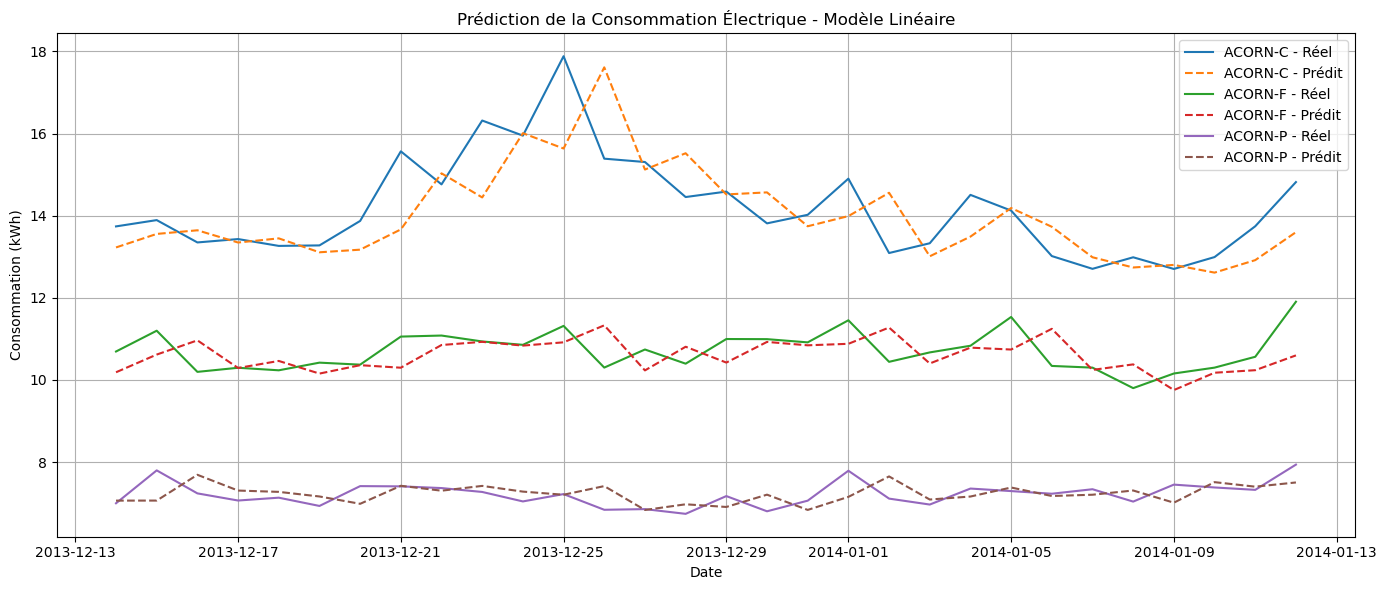

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

# Change working directory if needed
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

# Data loading
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')

# Data preprocessing
group_4_daily['Date'] = pd.to_datetime(group_4_daily['Date'])
weather_daily['time'] = pd.to_datetime(weather_daily['time'])
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')

# Sort by date
group_4_daily = group_4_daily.sort_values(['Acorn', 'Date'])

# Create lag and rolling features
group_4_daily['lag_1'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1)
group_4_daily['lag_2'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(2)
group_4_daily['lag_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(3)
group_4_daily['rolling_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1).rolling(3).mean().reset_index(0, drop=True)

# Merge weather on date
merged = pd.merge(group_4_daily, weather_daily, left_on='Date', right_on='time', how='left')

# Train/test sets split
cutoff = merged['Date'].max() - pd.Timedelta(days=30)
train = merged[merged['Date'] <= cutoff]
test = merged[merged['Date'] > cutoff]

# Drop rows with missing values (from lag features or weather)
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_3', 'temperatureMin', 'temperatureMax', 'humidity', 'windSpeed']
train = train.dropna(subset=features + ['Conso_kWh'])
test = test.dropna(subset=features)

# Training the model
X_train = train[features]
y_train = train['Conso_kWh']
X_test = test[features]
y_test = test['Conso_kWh']

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ RMSE on test set: {rmse:.4f}")

# Results visualization
# Reset index for alignment with y_pred
test_reset = test.reset_index(drop=True)

plt.figure(figsize=(14, 6))
for acorn in test_reset['Acorn'].unique():
    sub_test = test_reset[test_reset['Acorn'] == acorn]
    sub_pred = y_pred[sub_test.index]

    plt.plot(sub_test['Date'], sub_test['Conso_kWh'], label=f'{acorn} - Réel')
    plt.plot(sub_test['Date'], sub_pred, linestyle='--', label=f'{acorn} - Prédit')

plt.xlabel('Date')
plt.ylabel('Consommation (kWh)')
plt.title('Prédiction de la Consommation Électrique - Modèle Linéaire')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

✅ RMSE on validation set: 0.6161


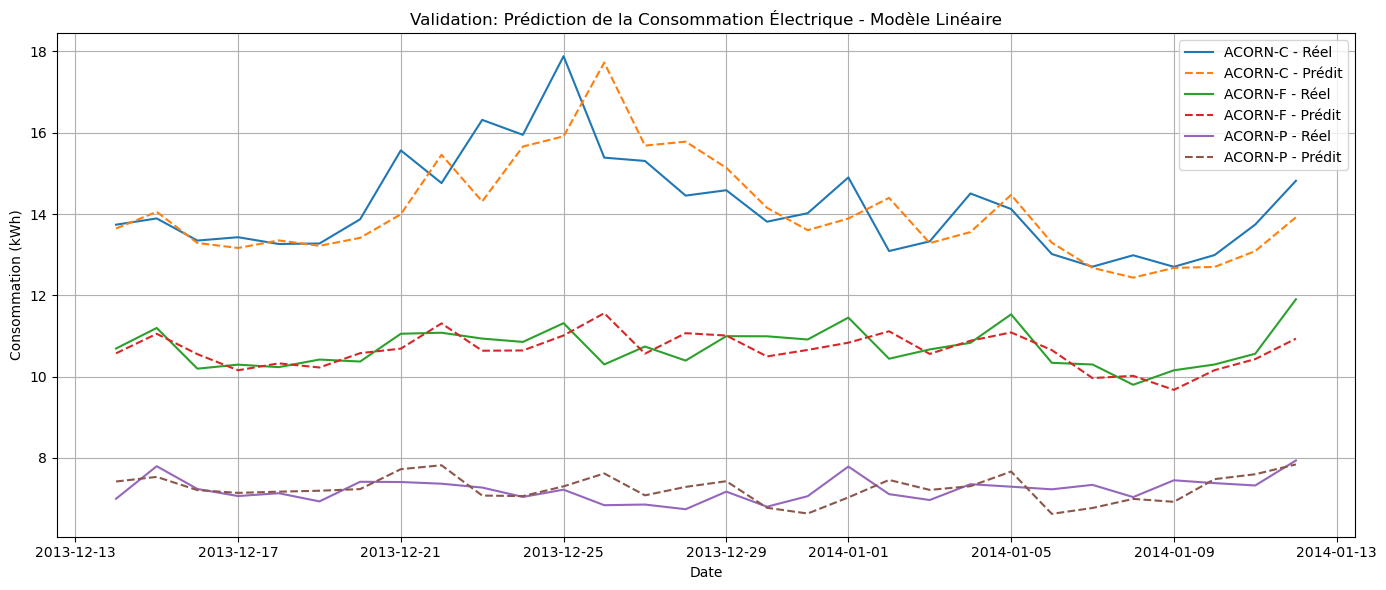

c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

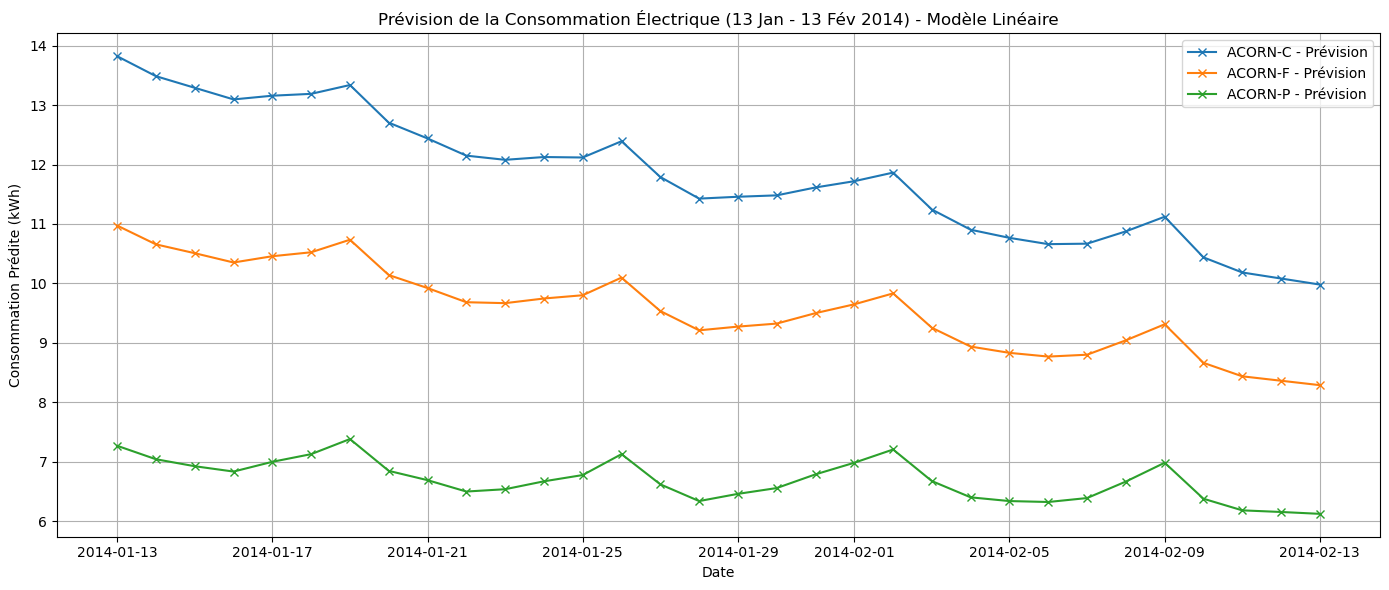

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

# Data loading
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')

# Data preprocessing
group_4_daily['Date'] = pd.to_datetime(group_4_daily['Date'])
weather_daily['time'] = pd.to_datetime(weather_daily['time'])
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')
holiday_dates = set(uk_bank_holidays['Bank holidays'].dt.date)

# Sort by date
group_4_daily = group_4_daily.sort_values(['Acorn', 'Date'])

# Calendar features
group_4_daily['DayOfWeek'] = group_4_daily['Date'].dt.dayofweek
group_4_daily['Month'] = group_4_daily['Date'].dt.month
group_4_daily['IsHoliday'] = group_4_daily['Date'].dt.date.isin(holiday_dates).astype(int)

# Lag and rolling features
group_4_daily['lag_1'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1)
group_4_daily['lag_2'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(2)
group_4_daily['lag_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(3)
group_4_daily['rolling_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1).rolling(3).mean().reset_index(0, drop=True)

# Merge weather on date
merged = pd.merge(group_4_daily, weather_daily, left_on='Date', right_on='time', how='left')

# Train/test sets split
cutoff = merged['Date'].max() - pd.Timedelta(days=30)
train = merged[merged['Date'] <= cutoff]
test = merged[merged['Date'] > cutoff]

features = [
    'lag_1', 'lag_2', 'lag_3', 'rolling_3',
    'temperatureMin', 'temperatureMax', 'humidity', 'windSpeed',
    'DayOfWeek', 'Month', 'IsHoliday'
]
train = train.dropna(subset=features + ['Conso_kWh'])
test = test.dropna(subset=features)

# Training the model
X_train = train[features]
y_train = train['Conso_kWh']

lr = LinearRegression()
lr.fit(X_train, y_train)

# Validation and RMSE calculation
X_test = test[features]
y_test = test['Conso_kWh']
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ RMSE on validation set: {rmse:.4f}")

# Visualization of validation results
test_reset = test.reset_index(drop=True)
plt.figure(figsize=(14, 6))
for acorn in test_reset['Acorn'].unique():
    sub_test = test_reset[test_reset['Acorn'] == acorn]
    sub_pred = y_pred[sub_test.index]
    plt.plot(sub_test['Date'], sub_test['Conso_kWh'], label=f'{acorn} - Réel')
    plt.plot(sub_test['Date'], sub_pred, linestyle='--', label=f'{acorn} - Prédit')
plt.xlabel('Date')
plt.ylabel('Consommation (kWh)')
plt.title('Validation: Prédiction de la Consommation Électrique - Modèle Linéaire')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Recursive forcasting
forecast_start = pd.Timestamp('2014-01-13')
forecast_end = pd.Timestamp('2014-02-13')
forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')

forecast_results = []

for acorn in group_4_daily['Acorn'].unique():
    acorn_hist = merged[merged['Acorn'] == acorn].sort_values('Date')
    last_known = acorn_hist[acorn_hist['Date'] < forecast_start].tail(3)
    if len(last_known) < 3:
        print(f"Not enough history for Acorn {acorn}, skipping.")
        continue
    lags = list(last_known['Conso_kWh'].values)
    rolling = np.mean(lags)
    last_date = last_known['Date'].iloc[-1]
    # Recursive prediction
    preds = []
    for date in forecast_dates:
        weather_row = weather_daily[weather_daily['time'] == date]
        if weather_row.empty:
            continue
        dayofweek = date.dayofweek
        month = date.month
        isholiday = int(date.date() in holiday_dates)
        features_row = [
            lags[-1], lags[-2], lags[-3], rolling,
            weather_row['temperatureMin'].values[0],
            weather_row['temperatureMax'].values[0],
            weather_row['humidity'].values[0],
            weather_row['windSpeed'].values[0],
            dayofweek, month, isholiday
        ]
        pred = lr.predict([features_row])[0]
        preds.append({'Date': date, 'Acorn': acorn, 'Predicted': pred})
        lags = lags[1:] + [pred]
        rolling = np.mean(lags)
    forecast_results.extend(preds)

forecast_df = pd.DataFrame(forecast_results)

# Visualization of forecast results
plt.figure(figsize=(14, 6))
for acorn in forecast_df['Acorn'].unique():
    sub_forecast = forecast_df[forecast_df['Acorn'] == acorn]
    plt.plot(sub_forecast['Date'], sub_forecast['Predicted'], marker='x', label=f'{acorn} - Prévision')
plt.xlabel('Date')
plt.ylabel('Consommation Prédite (kWh)')
plt.title('Prévision de la Consommation Électrique (13 Jan - 13 Fév 2014) - Modèle Linéaire')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

✅ RMSE on validation set (standard): 0.6161


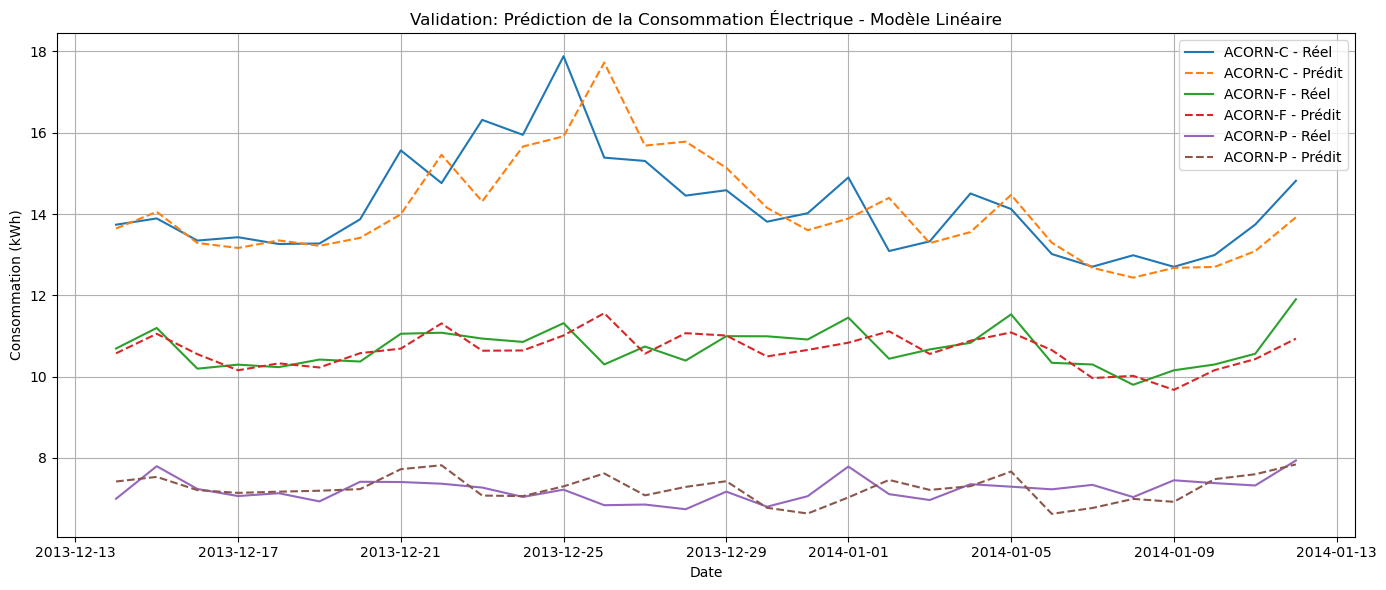

c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

✅ RMSE on validation set (recursive): 1.1567


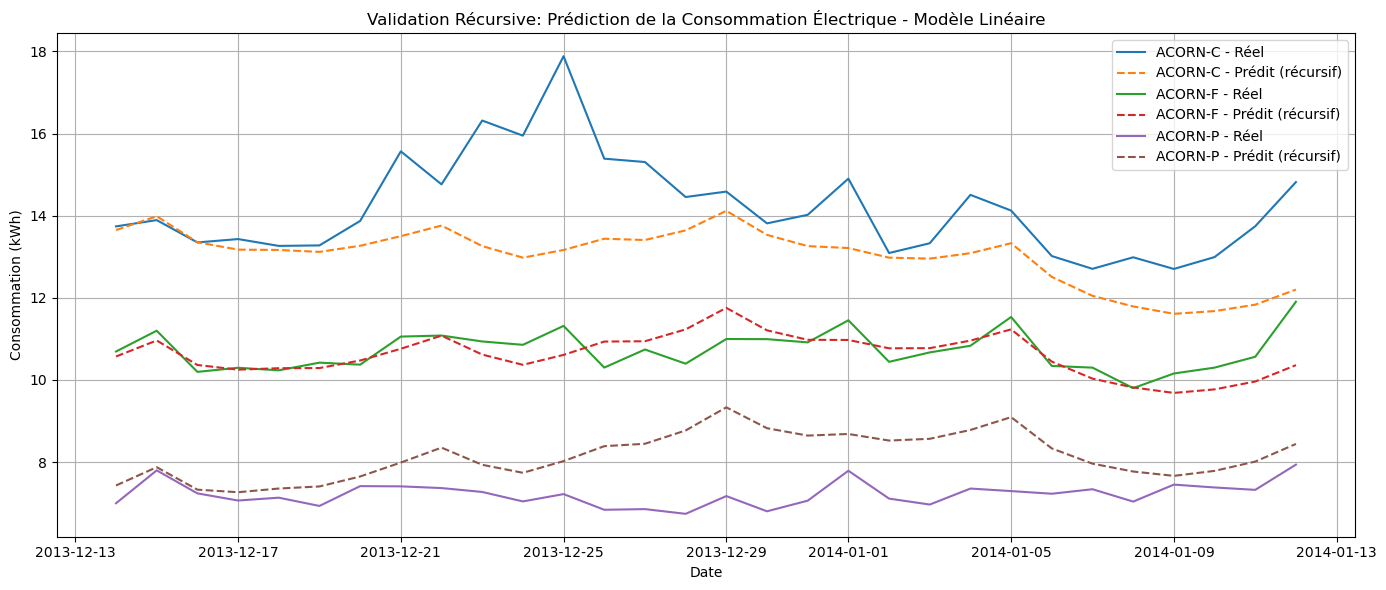

c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

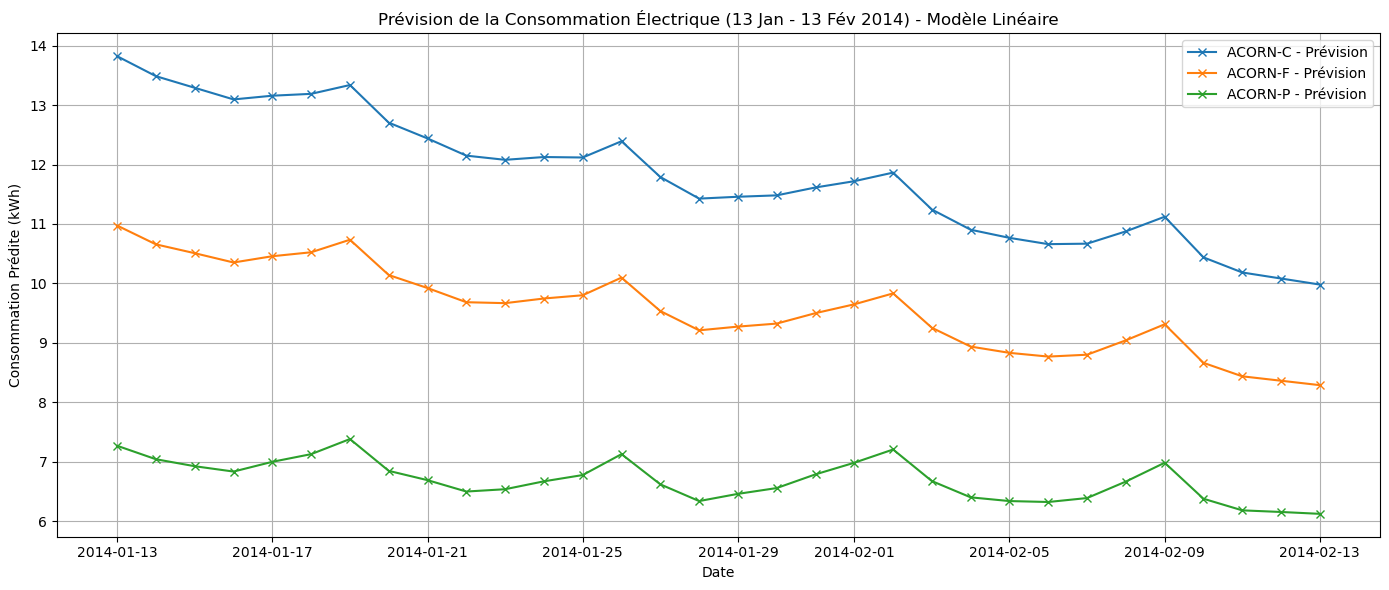

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

# Data loading
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')

# Data preprocessing
group_4_daily['Date'] = pd.to_datetime(group_4_daily['Date'])
weather_daily['time'] = pd.to_datetime(weather_daily['time'])
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')
holiday_dates = set(uk_bank_holidays['Bank holidays'].dt.date)

# Sort by date
group_4_daily = group_4_daily.sort_values(['Acorn', 'Date'])

# Calendar features
group_4_daily['DayOfWeek'] = group_4_daily['Date'].dt.dayofweek
group_4_daily['Month'] = group_4_daily['Date'].dt.month
group_4_daily['IsHoliday'] = group_4_daily['Date'].dt.date.isin(holiday_dates).astype(int)

# Lag and rolling features
group_4_daily['lag_1'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1)
group_4_daily['lag_2'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(2)
group_4_daily['lag_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(3)
group_4_daily['rolling_3'] = group_4_daily.groupby('Acorn')['Conso_kWh'].shift(1).rolling(3).mean().reset_index(0, drop=True)

# Merge weather on date
merged = pd.merge(group_4_daily, weather_daily, left_on='Date', right_on='time', how='left')

# Train/test sets split
cutoff = merged['Date'].max() - pd.Timedelta(days=30)
train = merged[merged['Date'] <= cutoff]
test = merged[merged['Date'] > cutoff]

features = [
    'lag_1', 'lag_2', 'lag_3', 'rolling_3',
    'temperatureMin', 'temperatureMax', 'humidity', 'windSpeed',
    'DayOfWeek', 'Month', 'IsHoliday'
]
train = train.dropna(subset=features + ['Conso_kWh'])
test = test.dropna(subset=features)

# Training the model
X_train = train[features]
y_train = train['Conso_kWh']

lr = LinearRegression()
lr.fit(X_train, y_train)

# Validation
X_test = test[features]
y_test = test['Conso_kWh']
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ RMSE on validation set (standard): {rmse:.4f}")

# Visualualization of validation results
test_reset = test.reset_index(drop=True)
plt.figure(figsize=(14, 6))
for acorn in test_reset['Acorn'].unique():
    sub_test = test_reset[test_reset['Acorn'] == acorn]
    sub_pred = y_pred[sub_test.index]
    plt.plot(sub_test['Date'], sub_test['Conso_kWh'], label=f'{acorn} - Réel')
    plt.plot(sub_test['Date'], sub_pred, linestyle='--', label=f'{acorn} - Prédit')
plt.xlabel('Date')
plt.ylabel('Consommation (kWh)')
plt.title('Validation: Prédiction de la Consommation Électrique - Modèle Linéaire')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Recursive validation
recursive_val_results = []

for acorn in test_reset['Acorn'].unique():
    acorn_hist = train[train['Acorn'] == acorn].sort_values('Date')
    last_known = acorn_hist.tail(3)
    if len(last_known) < 3:
        print(f"Not enough history for Acorn {acorn}, skipping recursive validation.")
        continue
    lags = list(last_known['Conso_kWh'].values)
    rolling = np.mean(lags)
    preds = []
    sub_test = test_reset[test_reset['Acorn'] == acorn]
    for idx, row in sub_test.iterrows():
        features_row = [
            lags[-1], lags[-2], lags[-3], rolling,
            row['temperatureMin'], row['temperatureMax'],
            row['humidity'], row['windSpeed'],
            row['DayOfWeek'], row['Month'], row['IsHoliday']
        ]
        pred = lr.predict([features_row])[0]
        preds.append({'Date': row['Date'], 'Acorn': acorn, 'Predicted': pred, 'Actual': row['Conso_kWh']})
        lags = lags[1:] + [pred]
        rolling = np.mean(lags)
    recursive_val_results.extend(preds)

recursive_val_df = pd.DataFrame(recursive_val_results)

# Compute RMSE for recursive validation
if not recursive_val_df.empty:
    rmse_recursive = np.sqrt(mean_squared_error(recursive_val_df['Actual'], recursive_val_df['Predicted']))
    print(f"✅ RMSE on validation set (recursive): {rmse_recursive:.4f}")

    # Plot recursive validation results
    plt.figure(figsize=(14, 6))
    for acorn in recursive_val_df['Acorn'].unique():
        sub_df = recursive_val_df[recursive_val_df['Acorn'] == acorn]
        plt.plot(sub_df['Date'], sub_df['Actual'], label=f'{acorn} - Réel')
        plt.plot(sub_df['Date'], sub_df['Predicted'], linestyle='--', label=f'{acorn} - Prédit (récursif)')
    plt.xlabel('Date')
    plt.ylabel('Consommation (kWh)')
    plt.title('Validation Récursive: Prédiction de la Consommation Électrique - Modèle Linéaire')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Recursive forecasting
forecast_start = pd.Timestamp('2014-01-13')
forecast_end = pd.Timestamp('2014-02-13')
forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')

forecast_results = []

for acorn in group_4_daily['Acorn'].unique():
    acorn_hist = merged[merged['Acorn'] == acorn].sort_values('Date')
    last_known = acorn_hist[acorn_hist['Date'] < forecast_start].tail(3)
    if len(last_known) < 3:
        print(f"Not enough history for Acorn {acorn}, skipping forecast.")
        continue
    lags = list(last_known['Conso_kWh'].values)
    rolling = np.mean(lags)
    preds = []
    for date in forecast_dates:
        weather_row = weather_daily[weather_daily['time'] == date]
        if weather_row.empty:
            continue
        dayofweek = date.dayofweek
        month = date.month
        isholiday = int(date.date() in holiday_dates)
        features_row = [
            lags[-1], lags[-2], lags[-3], rolling,
            weather_row['temperatureMin'].values[0],
            weather_row['temperatureMax'].values[0],
            weather_row['humidity'].values[0],
            weather_row['windSpeed'].values[0],
            dayofweek, month, isholiday
        ]
        pred = lr.predict([features_row])[0]
        preds.append({'Date': date, 'Acorn': acorn, 'Predicted': pred})
        lags = lags[1:] + [pred]
        rolling = np.mean(lags)
    forecast_results.extend(preds)

forecast_df = pd.DataFrame(forecast_results)

# Forecast results visualization
plt.figure(figsize=(14, 6))
for acorn in forecast_df['Acorn'].unique():
    sub_forecast = forecast_df[forecast_df['Acorn'] == acorn]
    plt.plot(sub_forecast['Date'], sub_forecast['Predicted'], marker='x', label=f'{acorn} - Prévision')
plt.xlabel('Date')
plt.ylabel('Consommation Prédite (kWh)')
plt.title('Prévision de la Consommation Électrique (13 Jan - 13 Fév 2014) - Modèle Linéaire')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()